Dice Similarity Coefficient: 0.9286746354919218
Intersection over Union Score: 0.8668464933791074


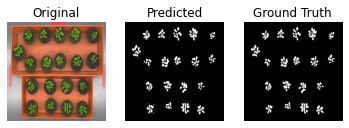

Dice Similarity Coefficient: 0.8987660237210974
Intersection over Union Score: 0.8161444734551784


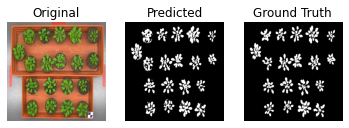

Dice Similarity Coefficient: 0.9019189765458422
Intersection over Union Score: 0.8213592233009709


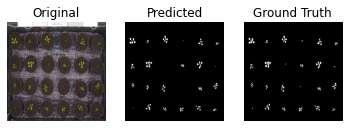

Dice Similarity Coefficient: 0.9219600725952813
Intersection over Union Score: 0.8552188552188552


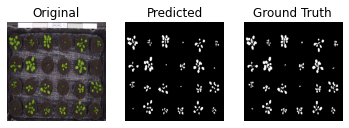

Dice Similarity Coefficient: 0.9134748045463504
Intersection over Union Score: 0.840730438988995


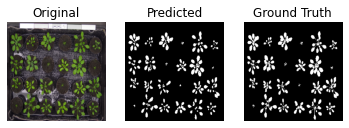

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

def IoU(img1, img2):
  img1 = np.asarray(img1).astype(np.bool)
  img2 = np.asarray(img2).astype(np.bool)

  if img1.shape != img2.shape:
    raise ValueError("Shape mismatch: img1 and img2 must have the same shape.")

  intersection = np.logical_and(img1, img2)
  union = np.logical_or(img1, img2)
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score

def dice(img1, img2, empty_score=1.0):
  img1 = np.asarray(img1).astype(np.bool)
  img2 = np.asarray(img2).astype(np.bool)

  if img1.shape != img2.shape:
    raise ValueError("Shape mismatch: img1 and img2 must have the same shape.")

  img_sum = img1.sum() + img2.sum()
  intersection = np.logical_and(img1, img2)
  dice_score = 2.*np.sum(intersection) / img_sum
  return dice_score

def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

"""# Model"""

def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='tanh', padding='same') (x)
  x = Conv2D(f, 3, activation='tanh', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='tanh', padding='same') (x)
    x = Conv2D(f, 3, activation='tanh', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='tanh', padding='same') (x)
  x = Conv2D(f, 3, activation='tanh', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

model = unet()

model.load_weights('/content/drive/My Drive/CV_project/weights.h5')

"""## Prediction"""

predict_files=[]
fg_files=[]
for file in os.listdir('/content/drive/My Drive/CV_project/predicts'):
  if file.endswith('rgb.png'):
    predict_files.append('/content/drive/My Drive/CV_project/predicts/'+file) 
  elif file.endswith('fg.png'):
    fg_files.append('/content/drive/My Drive/CV_project/predicts/'+file) 

predict_files.sort()
fg_files.sort()

for i in range(len(predict_files)):
  raw = Image.open(predict_files[i])
  raw = np.array(raw.resize((256, 256)))/255.
  raw = raw[:,:,0:3]

  GT = Image.open(fg_files[i])
  GT = np.array(GT.resize((256, 256)))

  #predict the mask 
  pred = model.predict(np.expand_dims(raw, 0))

  #mask post-processing 
  msk  = pred.squeeze()
  msk[msk >= 0.5] = 1 
  msk[msk < 0.5] = 0 
  
  #show dice similarity coefficient
  print(f'Dice Similarity Coefficient: {dice(msk,GT)}')
  #show IoU score
  print(f'Intersection over Union Score: {IoU(msk,GT)}')

  #show and save original, prediction and ground truth: 
  fig = plt.figure()
  original = fig.add_subplot(131)
  original.imshow(raw)
  predicted = fig.add_subplot(132)
  predicted.imshow(msk,cmap='gray')
  ground_truth = fig.add_subplot(133)
  ground_truth.imshow(GT,cmap='gray')
  original.title.set_text('Original')
  original.axis('off')
  predicted.title.set_text('Predicted')
  predicted.axis('off')
  ground_truth.title.set_text('Ground Truth')
  ground_truth.axis('off')
  fig.savefig(predict_files[i][:-7]+'predict'+'.png')
  plt.show()